# Importing libraries and data

In [ ]:
!pip install eli5

In [470]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy import where

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import pyplot

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score,roc_curve
from imblearn.over_sampling import SMOTE

In [472]:
data = pd.read_csv('loan.csv')

In [473]:
data.describe()

,Unnamed: 0,id,loan_amnt,funded_amnt,installment,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int
count,10000.000000,1.000000e+04,10000.000000,10000.00000,9524.000000,9524.000000,9524.000000,9524.000000,4100.000000,9524.000000,9524.000000,9524.000000,9524.000000,9524.000000,9524.000000,9524.000000
mean,100010.000000,5.143648e+06,14054.807500,14052.73000,442.626605,71655.752245,17.146927,0.238765,34.988537,11.043784,15982.998215,24.517640,10253.674229,5225.240946,3808.501311,1412.893987
std,57737.913598,2.827944e+06,8108.658728,8107.69323,244.522116,45362.834495,7.591601,0.691455,21.474509,4.561028,15177.648105,10.887693,7963.300050,5499.478657,4801.501191,1489.227516
min,20.000000,5.712030e+05,1000.000000,1000.00000,30.440000,7500.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,34.140000,22.500000,11.640000
25%,50015.000000,2.300882e+06,8000.000000,8000.00000,266.575000,45000.000000,11.520000,0.000000,17.000000,8.000000,7151.000000,17.000000,4273.387500,1676.312500,1027.525000,468.112500
50%,100010.000000,5.605038e+06,12000.000000,12000.00000,398.510000,61000.000000,16.840000,0.000000,32.000000,10.000000,12495.000000,23.000000,8745.425000,3500.040000,2237.870000,947.000000
75%,150005.000000,7.435741e+06,19400.000000,19400.00000,576.737500,86000.000000,22.590000,0.000000,49.000000,14.000000,20596.000000,31.000000,15055.437500,6736.965000,4544.470000,1777.870000
max,200000.000000,1.012507e+07,35000.000000,35000.00000,1388.450000,1000000.000000,34.980000,11.000000,122.000000,39.000000,376679.000000,68.000000,34413.520000,44231.080000,35000.010000,13514.550000


# Formatting, Cleaning and Dealing with NaN

In [474]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              10000 non-null  int64  
 1   id                      10000 non-null  int64  
 2   loan_amnt               10000 non-null  int64  
 3   funded_amnt             10000 non-null  int64  
 4   term                    9524 non-null   object 
 5   int_rate                9524 non-null   object 
 6   installment             9524 non-null   float64
 7   emp_length              9119 non-null   object 
 8   home_ownership          9524 non-null   object 
 9   annual_inc              9524 non-null   float64
 10  loan_status             9524 non-null   object 
 11  purpose                 9524 non-null   object 
 12  addr_state              10000 non-null  object 
 13  dti                     9524 non-null   float64
 14  delinq_2yrs             9524 non-null  

There are 10,000 rows and 23 columns in total from the csv file. There are a lot of columns containing NaN value which will be a problem when plotting the graph in the data exploration part or conducting the model for classification.


In [475]:
#'Unnamed: 0' column is dropped because there is no meaning
#'funded_amnt'column is dropped because the data is redundant to 'loan_amnt' 
data = data.drop(['Unnamed: 0','funded_amnt'],axis=1)

def loan_type(row):
    if row['loan_status'] in ['Current','Fully Paid']:
        val=0
    else:
        val=1
    return val

# 'loan_type' column is created to represent bad loan and good loan depending on the value in 'loan_status'
data['loan_type'] = data.apply(loan_type,axis=1)

In [476]:
#'duration_cr_line' column is created to represent the duration from 'earliest_cr_line' column and present time
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], infer_datetime_format=True)
data['duration_cr_line'] = (pd.to_datetime("now")-data['earliest_cr_line']).dt.days

In [477]:
#'mths_since_last_delinq'column contains the most NaN value because there are a lot of borrowers with no delinquency history. The lower number represents the recent history, therefore, the higher number, the better credit history of the borrower. Therefore, I replace NaN value for the borrowers with no delinquency history to be 1,000.
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].fillna(1000.0)

#Remove NaN from annual_inc and emp_length
data = data.dropna(subset=['annual_inc','emp_length'])

#Change the data type of int_rate and term
data['int_rate'] = data.apply(lambda x: float(x['int_rate'][0:-1])/100,axis=1)
data['term'] = data.apply(lambda x: int(x['term'].split()[0]),axis=1)

In [478]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9119 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      9119 non-null   int64         
 1   loan_amnt               9119 non-null   int64         
 2   term                    9119 non-null   int64         
 3   int_rate                9119 non-null   float64       
 4   installment             9119 non-null   float64       
 5   emp_length              9119 non-null   object        
 6   home_ownership          9119 non-null   object        
 7   annual_inc              9119 non-null   float64       
 8   loan_status             9119 non-null   object        
 9   purpose                 9119 non-null   object        
 10  addr_state              9119 non-null   object        
 11  dti                     9119 non-null   float64       
 12  delinq_2yrs             9119 non-null   float64 

# Encoding Categorial Column

In [479]:
home_encoder = pd.get_dummies(data["home_ownership"],prefix='home_type')
purpose_encoder =  pd.get_dummies(data["purpose"],prefix='purpose')

In [480]:
OH_columns = ['home_ownership','purpose']
data = data.drop(OH_columns,axis=1)
data = pd.concat([data,home_encoder,purpose_encoder],axis=1)

In [481]:
emp_length_sort = ['< 1 year','1 year', '2 years', '3 years','4 years',  '5 years', '6 years', '7 years','8 years', '9 years','10+ years']
def emp_sort(row):  
  return emp_length_sort.index(row['emp_length'])
    
data['le_emp_length'] = data.apply(emp_sort,axis=1)

In [482]:
clean_data = data.drop(['emp_length','loan_status','addr_state','id'],axis=1)

In [483]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9119 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   loan_amnt                   9119 non-null   int64         
 1   term                        9119 non-null   int64         
 2   int_rate                    9119 non-null   float64       
 3   installment                 9119 non-null   float64       
 4   annual_inc                  9119 non-null   float64       
 5   dti                         9119 non-null   float64       
 6   delinq_2yrs                 9119 non-null   float64       
 7   earliest_cr_line            9119 non-null   datetime64[ns]
 8   mths_since_last_delinq      9119 non-null   float64       
 9   open_acc                    9119 non-null   float64       
 10  revol_bal                   9119 non-null   float64       
 11  total_acc                   9119 non-null   float64     

# Data exploration

In [484]:
data['loan_status'].value_counts()

Current               7769
Fully Paid             921
Charged Off            209
Late (31-120 days)     140
In Grace Period         46
Late (16-30 days)       19
Default                 15
Name: loan_status, dtype: int64

Text(0, 0.5, 'Number of borrowers')

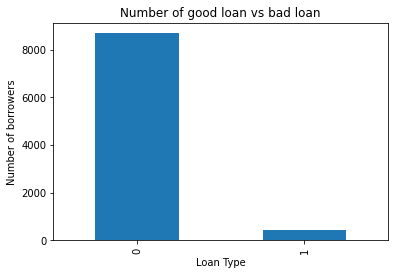

In [485]:

type_count = clean_data['loan_type'].value_counts()
type_count.plot(kind="bar")

plt.title("Number of good loan vs bad loan")
plt.xlabel("Loan Type")
plt.ylabel("Number of borrowers")

We can see that the positive case(bad loan) accounts only 5% of all data. This is common for the data like fraud detections that the dataset is highly imbalanced.

## feature inspection and outlier check

## loan amount

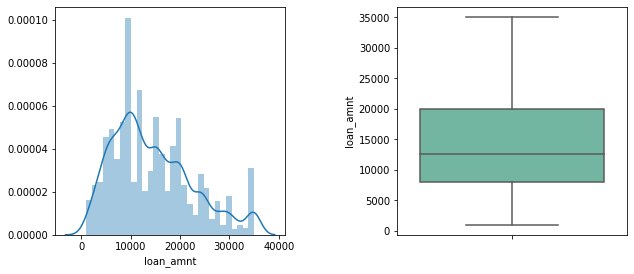

In [486]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(clean_data["loan_amnt"], ax=axes[0]);
sns.boxplot(clean_data["loan_amnt"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

There is no outlier in loan amount column

## Installment

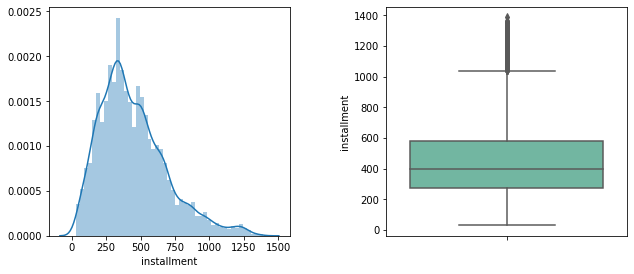

In [487]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(clean_data["installment"], ax=axes[0]);
sns.boxplot(clean_data["installment"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

There is a bunch of outlier in installment data so I will use PowerTransformer to manage the outlier.

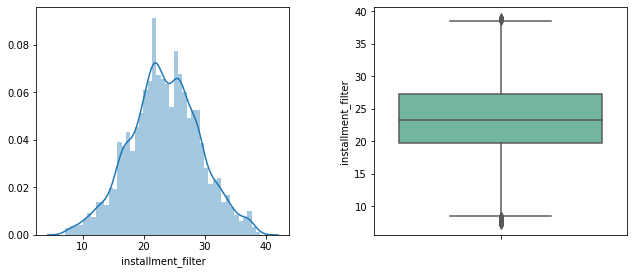

In [488]:
pt = PowerTransformer(method="yeo-johnson", standardize=False)
pt.fit(clean_data["installment"].values.reshape(-1, 1))

clean_data['installment_filter'] = pt.transform(clean_data["installment"].values.reshape(-1, 1))

fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(clean_data['installment_filter'], ax=axes[0]);
sns.boxplot(clean_data['installment_filter'], orient="v", palette="Set2", ax=axes[1])
fig.tight_layout(pad=5.0)

There are still some remaining outlier so I will remove those outlier which is greater than 1.5quantile

In [489]:
Q1 = clean_data['installment_filter'].quantile(0.25)
Q3 = clean_data['installment_filter'].quantile(0.75)
IQR = Q3 - Q1 

filter = (clean_data['installment_filter'] >= Q1 - 1.5 * IQR) & (clean_data['installment_filter'] <= Q3 + 1.5 *IQR)
data_2=data.loc[filter] 

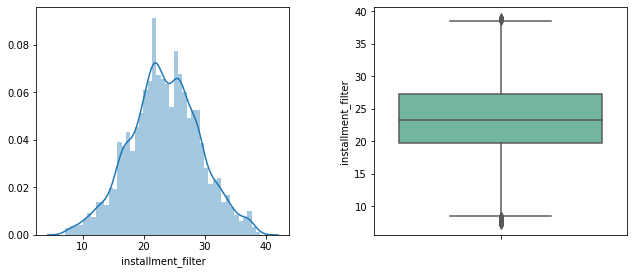

In [490]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(clean_data['installment_filter'], ax=axes[0]);
sns.boxplot(clean_data['installment_filter'], orient="v", palette="Set2", ax=axes[1])
fig.tight_layout(pad=5.0)

## Annual Income

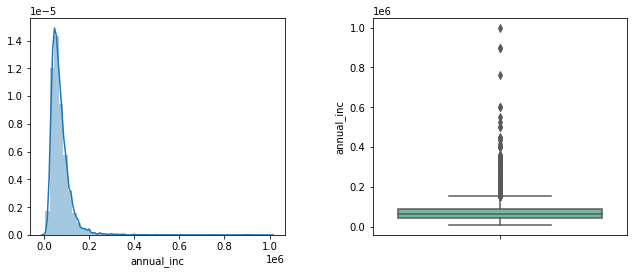

In [491]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(clean_data["annual_inc"], ax=axes[0]);
sns.boxplot(clean_data["annual_inc"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

In [492]:
clean_data["annual_inc_int"] = pd.cut(data["annual_inc"],
                                bins=7,
                                labels=[0,1,2,3,4,5,6],
                                include_lowest=True)

In [493]:
clean_data["annual_inc_int"].value_counts()

0    8696
1     373
2      38
3       6
6       3
4       2
5       1
Name: annual_inc_int, dtype: int64

In [494]:
clean_data = clean_data[clean_data.annual_inc_int <2]

A lot of customer has annual income from $0-$200,000 so the right side of the distribution is almost flat. The powertransform cannot use with this kind of data. After grouping the data into 7 bins , I remove the data from 2-6 which is less than 5% of all data

## Outstanding Principal

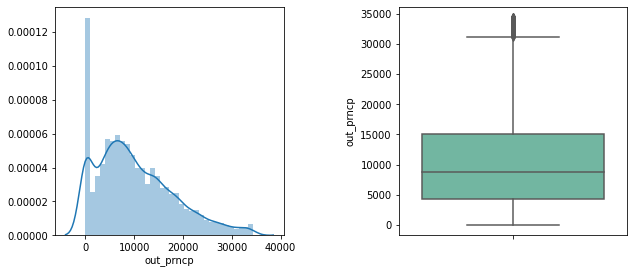

In [495]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(clean_data["out_prncp"], ax=axes[0]);
sns.boxplot(clean_data["out_prncp"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

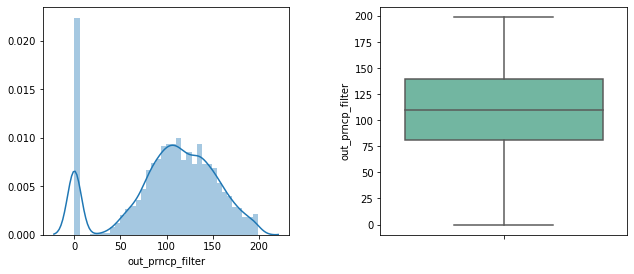

In [496]:
pt = PowerTransformer(method="yeo-johnson", standardize=False)
pt.fit(clean_data["out_prncp"].values.reshape(-1, 1))

clean_data['out_prncp_filter'] = pt.transform(clean_data["out_prncp"].values.reshape(-1, 1))

fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(clean_data['out_prncp_filter'], ax=axes[0]);
sns.boxplot(clean_data['out_prncp_filter'], orient="v", palette="Set2", ax=axes[1])
fig.tight_layout(pad=5.0)

## Finding the correlation

In [497]:
clean_df = clean_data.drop(["out_prncp","annual_inc_int","installment"],axis=1)

In [498]:
corr_matrix = clean_df.corr()
corr_matrix

,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,open_acc,revol_bal,total_acc,total_pymnt,total_rec_prncp,total_rec_int,loan_type,duration_cr_line,home_type_MORTGAGE,home_type_NONE,home_type_OTHER,home_type_OWN,home_type_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,le_emp_length,installment_filter,out_prncp_filter
loan_amnt,1.000000,0.444743,0.200195,0.449657,0.044929,0.028323,0.000673,0.181515,0.389553,0.231414,0.471781,0.346096,0.623688,0.002709,0.208296,0.198674,0.000819,0.007295,-0.032271,-0.184080,-0.065107,0.001298,0.117052,-0.008504,0.025416,-0.071160,-0.074578,-0.059192,-0.123618,-0.021926,0.025512,-0.070890,-0.042708,0.119949,0.943602,0.592253
term,0.444743,1.000000,0.474647,0.105490,0.079908,0.021518,-0.005536,0.068582,0.131296,0.114527,0.102684,-0.014460,0.424386,0.035307,0.080220,0.122164,-0.005911,-0.005911,-0.007693,-0.119632,-0.019996,-0.062262,0.069542,0.027489,0.005966,-0.016263,-0.036054,-0.009602,-0.006428,-0.012204,-0.001928,-0.032406,-0.026844,0.082134,0.235361,0.341100
int_rate,0.200195,0.474647,1.000000,-0.026623,0.142558,0.122615,-0.139609,0.011498,-0.002610,-0.014824,0.081043,-0.037569,0.417982,0.090388,-0.084932,-0.103732,-0.005155,-0.000481,0.014796,0.097291,-0.032447,-0.131274,0.038591,-0.014464,0.009958,-0.040951,0.054445,0.046866,0.140068,0.014824,0.041406,0.041224,0.025235,0.023269,0.155993,0.135398
annual_inc,0.449657,0.105490,-0.026623,1.000000,-0.232210,0.090248,-0.093716,0.192523,0.396084,0.292222,0.218316,0.180613,0.223820,-0.051358,0.231993,0.252690,0.007852,0.005543,-0.069038,-0.218526,-0.014815,-0.010393,-0.027945,0.084699,0.040573,0.027742,-0.018737,-0.011688,-0.028520,-0.007108,0.031647,-0.007993,-0.008214,0.094905,0.418612,0.255081
dti,0.044929,0.079908,0.142558,-0.232210,1.000000,-0.018057,0.005091,0.289135,0.176576,0.227370,-0.041145,-0.067448,0.064609,0.045568,0.030535,-0.014729,0.016890,0.022285,0.012747,0.007002,-0.030303,0.007272,0.091084,-0.089427,-0.049399,-0.064254,-0.013488,-0.005564,-0.013679,0.000332,-0.059848,-0.000032,-0.013285,0.046672,0.051695,0.081020
delinq_2yrs,0.028323,0.021518,0.122615,0.090248,-0.018057,1.000000,-0.414101,0.051955,-0.008896,0.143966,0.000363,-0.008193,0.027561,0.010789,0.096312,0.059086,-0.003646,-0.003646,-0.001265,-0.059203,-0.015830,-0.035108,0.012564,0.016426,0.018330,0.012896,-0.001800,0.019029,0.006333,-0.007553,0.008812,0.000256,0.000946,0.051780,0.032970,0.013380
mths_since_last_delinq,0.000673,-0.005536,-0.139609,-0.093716,0.005091,-0.414101,1.000000,-0.057364,0.072024,-0.220408,0.009175,0.017868,-0.023761,0.008599,-0.160563,-0.072553,-0.011574,-0.011310,0.004567,0.071689,0.020733,0.052799,-0.032110,-0.033517,-0.003309,0.002683,-0.017163,0.015789,-0.017104,0.004923,0.015462,-0.001492,0.008183,-0.051287,-0.017461,-0.012553
open_acc,0.181515,0.068582,0.011498,0.192523,0.289135,0.051955,-0.057364,1.000000,0.251030,0.670185,0.037031,0.016859,0.082090,-0.025772,0.166171,0.146702,0.013685,0.020609,-0.025125,-0.135805,-0.012881,0.008193,0.052070,-0.025562,-0.025161,-0.024685,0.001796,-0.014347,-0.042685,-0.012383,-0.025280,-0.022146,-0.026091,0.042743,0.186499,0.150547
revol_bal,0.389553,0.131296,-0.002610,0.396084,0.176576,-0.008896,0.072024,0.251030,1.000000,0.247819,0.158842,0.120785,0.196779,-0.024866,0.247918,0.170362,0.022835,0.020846,-0.003621,-0.172093,-0.021145,0.064925,0.020518,-0.056043,0.005347,-0.019809,-0.030499,-0.023072,-0.052077,-0.010830,-0.017139,-0.014060,-0.029889,0.120695,0.364885,0.247889
total_acc,0.231414,0.114527,-0.014824,0.292222,0.227370,0.143966,-0.220408,0.670185,0.247819,1.000000,0.088964,0.071092,0.099494,-0.027219,0.306246,0.233986,0.010085,0.017805,-0.032481,-0.220283,-0.016368,-0.016025,0.060649,0.002226,-0.014781,-0.028464,-0.004808,-0.019283,-0.039628,-0.010788,-0.025360,-0.01871

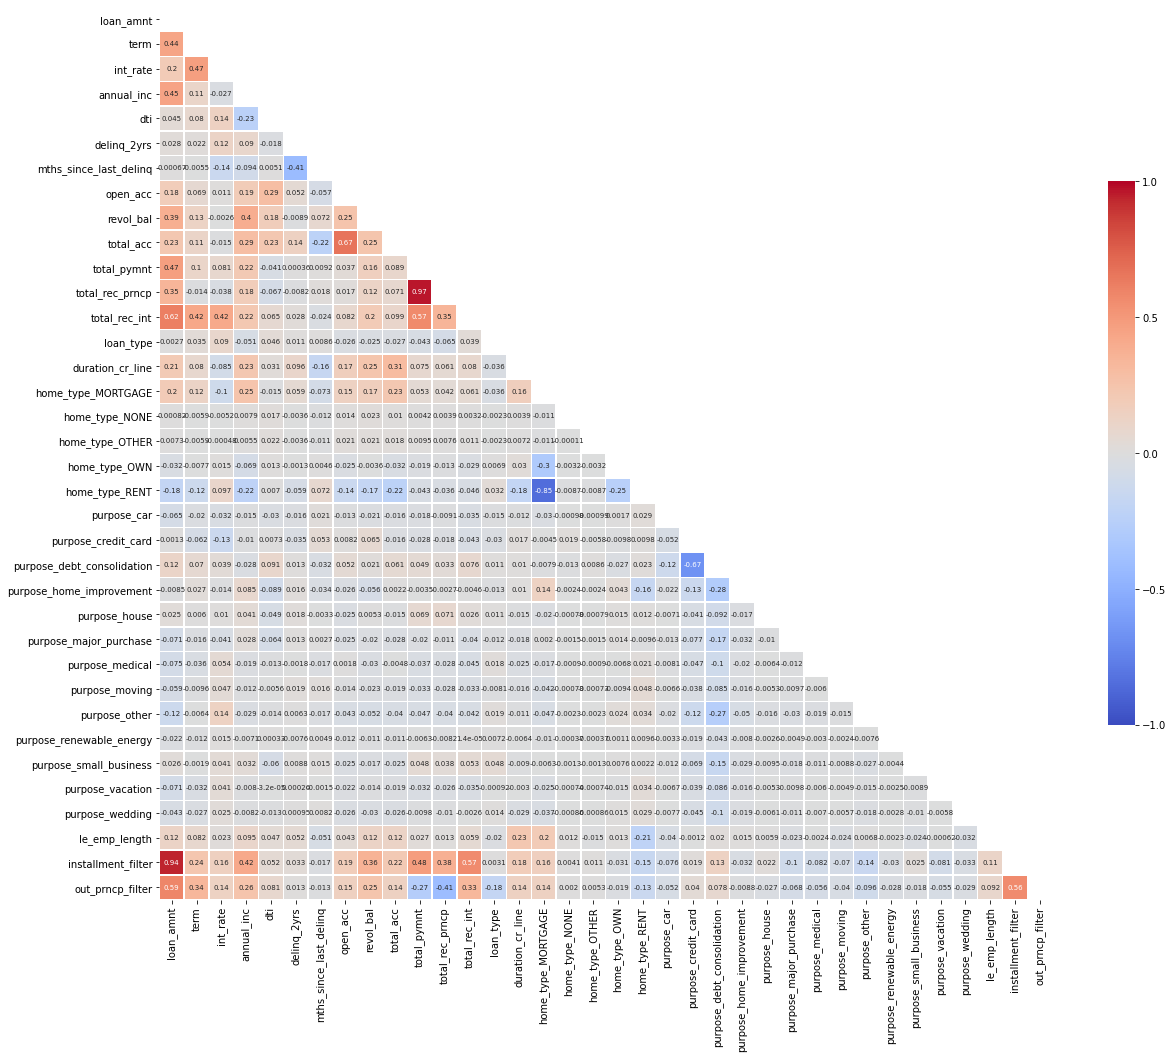

In [499]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
f, ax = plt.subplots(figsize=(20, 20)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .5, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 7})

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

From the correlation analysis, we can see some relationships :

1.Installment has a direct correlation with the amount of loan

2.Outstanding principal has a direct correlation with the amount of loan

3.Total received principal on the loan has a direct correlation with total payment, installment and total payment on the loan

4.The higher monthly installment, the higher outstanding principal and received interest on the loan.

5.The longer period since the borrower's last delinquency, the less frequency of the borrower's delinquencies in the last 2 years.

6.Duration of the credit line has a direct relationship with the number of the borrower’s total credit accounts, including currently open & closed

7.The borrower who lends the loan for home improvement is likely to be under the mortgage.

8.The borrower with longer employment length is less likely to rent the house.

9.Interest rate has the highest association with the loan type which means that the higher the interest rate, the higher chance that the loan will become a bad loan.


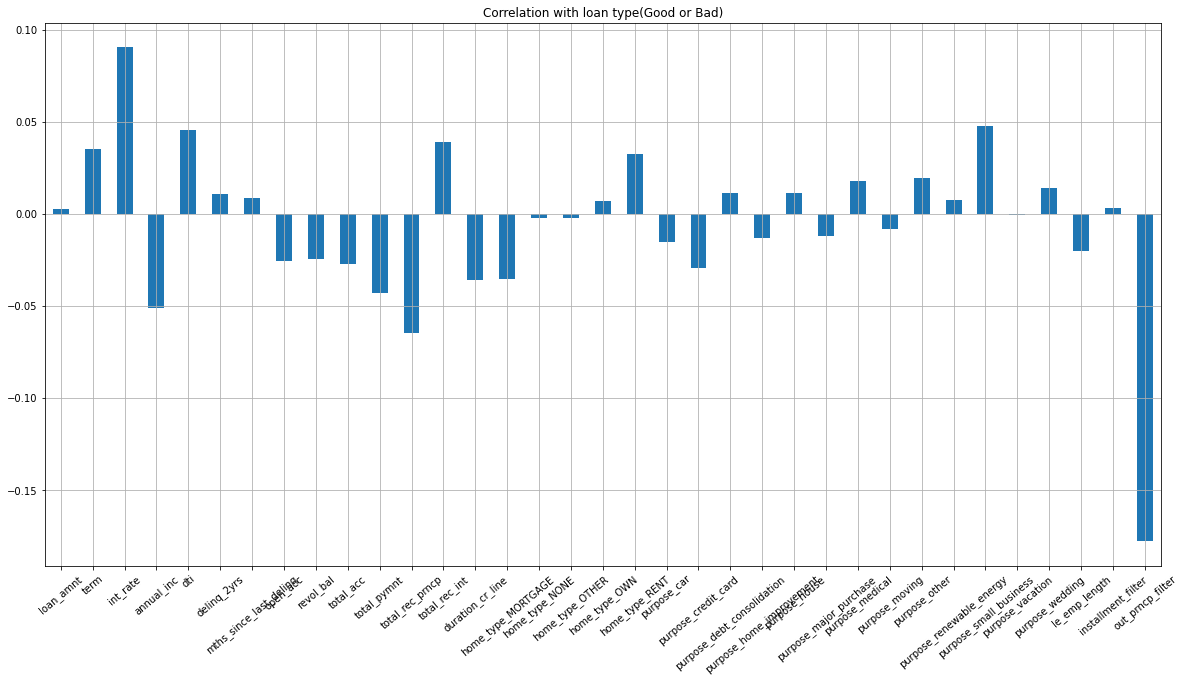

In [500]:
clean_df2 = clean_df.drop(columns=['loan_type'])
clean_df2.corrwith(clean_df.loan_type).plot.bar(figsize = (20, 10), title = "Correlation with loan type(Good or Bad)", fontsize = 10,rot = 40, grid = True)

Text(0.5, 1.0, 'Interest rate Distribution')

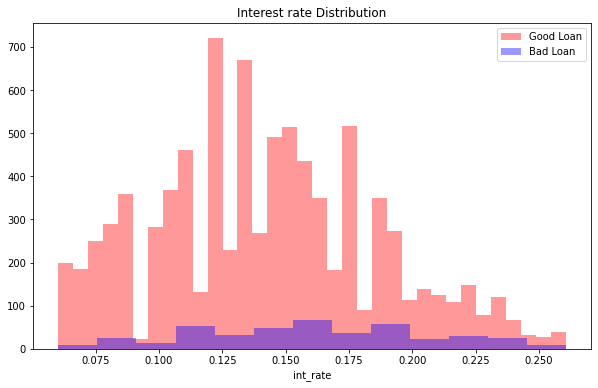

In [501]:
#As interest rate has the highest correlation to the loan type,I want to see whether there is any sighnificant insight

plt.figure(figsize=(10,6))
sns.distplot(clean_df[clean_df["loan_type"] == 0]['int_rate'], color = 'r',label='Good Loan',kde=False)
sns.distplot(clean_df[clean_df["loan_type"] == 1]['int_rate'], color = 'b',label='Bad Loan',kde=False)
plt.legend()
plt.title("Interest rate Distribution")

# Split and standardize the data

Splitting the data to train,test in 80-20.
There is no validation because the model that I'm going to use doesn't require a lot of finetuning.
StandardScaler is used to create standardization in the dataset.

In [502]:
y= clean_df.loan_type
X = clean_df.drop(['loan_type','earliest_cr_line'],axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [503]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)

In [504]:
X_test_scaler = scaler.transform(X_test)

# Method 1 : Random Forest

In [505]:
random_forest = RandomForestClassifier(n_estimators=150,random_state=0,bootstrap = True,max_features = 'sqrt')
random_forest.fit(X_train_scaler, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [506]:
random_forest.score(X_test_scaler,y_test)

0.9746416758544653

In [507]:
pred1 = random_forest.predict(X_test_scaler)
f1_score(pred1,y_test)

0.5576923076923077

[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted')]

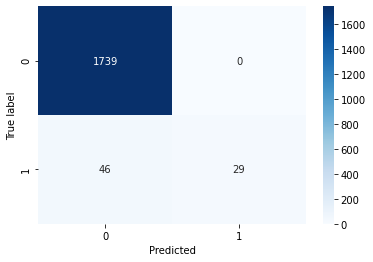

In [508]:
cm = confusion_matrix(y_test,pred1)
labels = [cm[0,0],cm[0,1],cm[1,0],cm[1,1]]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='True label')

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.41')

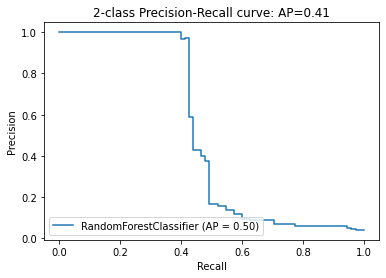

In [510]:
y_score_rf = random_forest.predict(X_test_scaler)
average_precision = average_precision_score(y_test, y_score)

disp = plot_precision_recall_curve(random_forest, X_test_scaler, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [511]:
roc_auc_score(y_test, y_score_rf)

0.6933333333333334

## using SMOTE - Synthetic Minority Over-sampling Technique
SMOTE is a popular technique to deal with highly imbalanced dataset. However, after trying this method, the f1_score is lower. Therefore, it might not be a good option for this dataset.

In [512]:
oversample = SMOTE()
X_train_smote,y_train_smote = oversample.fit_resample(X_train_scaler,y_train)
counter = Counter(y_train_smote)
print(counter)

Counter({0: 6902, 1: 6902})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


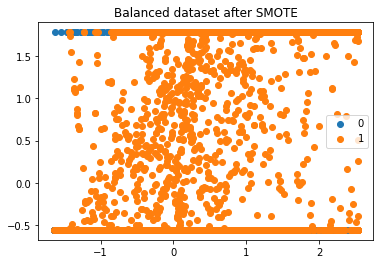

In [513]:
for label, _ in counter.items():
	row_ix = where(y_train_smote == label)[0]
	pyplot.scatter(X_train_smote[row_ix, 0], X_train_smote[row_ix, 1], label=str(label))
pyplot.title('Balanced dataset after SMOTE')
pyplot.legend()
pyplot.show()

In [514]:
random_forest.fit(X_train_smote,y_train_smote)
pred2 = random_forest.predict(X_test_scaler)

In [515]:
random_forest.score(X_test_scaler,y_test)

0.9735391400220507

In [516]:
f1_score(pred2,y_test)

0.5714285714285715

[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted')]

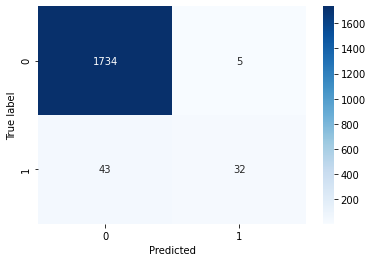

In [517]:
cm = confusion_matrix(y_test,pred2)
labels = [cm[0,0],cm[0,1],cm[1,0],cm[1,1]]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='True label')

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.61')

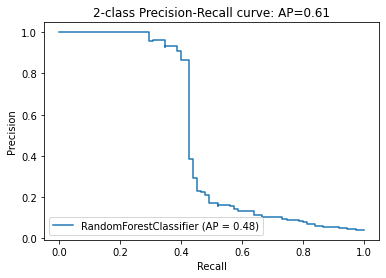

In [518]:
y_score = model2.predict(X_test_scaler)
average_precision = average_precision_score(y_test, y_score)

disp = plot_precision_recall_curve(random_forest, X_test_scaler, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
roc_auc_score(y_test, y_score)

0.5226426799007444

## Using RandomUnderSampler

Undersampling is another technique to deal with highly imbalanced dataset. However, the result does not significantly improve as well.

In [519]:
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus= rus.fit_resample(X_train_scaler, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [520]:
random_forest.fit(X_train_rus,y_train_rus)
pred3 = random_forest.predict(X_test_scaler)

In [521]:
random_forest.score(X_test_scaler,y_test)

0.8230429988974641

In [522]:
f1_score(pred3,y_test)

0.218978102189781

[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted')]

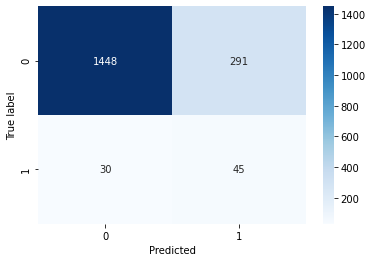

In [523]:
cm = confusion_matrix(y_test,pred3)
labels = [cm[0,0],cm[0,1],cm[1,0],cm[1,1]]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='True label')

# Method 2: Decision Tree Classifier

As SMOTE and Undersampling don't provide a significant improvement on the f1_score. I won't use them in this model.

In [524]:
decc=DecisionTreeClassifier()
decc.fit(X_train_scaler,y_train.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [525]:
y_pred_decc=decc.predict(X_test_scaler)

In [526]:
decc.score(X_test_scaler,y_test)

0.9509371554575524

In [527]:
f1_score(y_pred_decc,y_test)

0.41830065359477125

[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted')]

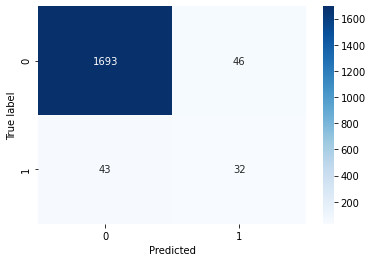

In [528]:
cm = confusion_matrix(y_test,y_pred_decc)
labels = [cm[0,0],cm[0,1],cm[1,0],cm[1,1]]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='True label')

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.61')

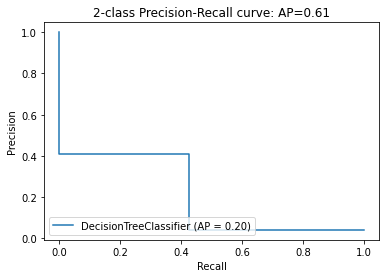

In [529]:
y_score_decc = decc.predict(X_test_scaler)
average_precision = average_precision_score(y_test, y_score)

disp = plot_precision_recall_curve(decc, X_test_scaler, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [530]:
roc_auc_score(y_test, y_score_decc)

0.7001073413839372

# Method 3: Deep Learning Model (Keras)

In [532]:
keras_model = Sequential([
      Dense(units=16, input_dim=35, activation='relu'),
      Dense(units=24,activation='relu'),
      Dropout(0.5),
      Dense(20,activation='relu'),
      Dense(24,activation='relu'),
      Dense(1,activation='sigmoid')   
])

In [533]:
keras_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
keras_model.fit(X_train_scaler,y_train, batch_size=15, epochs=5)

Epoch 1/5
484/484 [==============================] - 1s 2ms/step - loss: 0.2316 - accuracy: 0.9505
Epoch 2/5
484/484 [==============================] - 1s 1ms/step - loss: 0.1828 - accuracy: 0.9512
Epoch 3/5
484/484 [==============================] - 1s 1ms/step - loss: 0.1622 - accuracy: 0.9541
Epoch 4/5
484/484 [==============================] - 1s 2ms/step - loss: 0.1437 - accuracy: 0.9651
Epoch 5/5
484/484 [==============================] - 1s 1ms/step - loss: 0.1314 - accuracy: 0.9694


In [534]:
score=keras_model.evaluate(X_test_scaler,y_test)
print(score)

57/57 [==============================] - 0s 1ms/step - loss: 0.1193 - accuracy: 0.9741
[0.11926782876253128, 0.9740903973579407]


In [535]:
y_pred_keras=(keras_model.predict(X_test_scaler).ravel()>0.5).astype(int)

In [536]:
f1_score(y_pred_keras,np.array(y_test))

0.5523809523809524

[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted')]

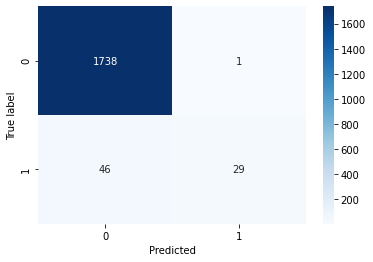

In [537]:
cm = confusion_matrix(y_test,y_pred_keras)
labels = [cm[0,0],cm[0,1],cm[1,0],cm[1,1]]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='True label')